# Clearing Probability Notebook

<b>Description:</b> This notebook provides an example of how to calculate the probability a bid clears the market

In [2]:
%load_ext autoreload

In [165]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.BidSimulator import BidSimulator
from scipy.stats import norm
from scipy.stats import kstest

## Load and Preprocess CAISO Data

In [7]:
# load day-ahead and real-time prices
DAP = pd.read_csv("./data/CAISO_DAP.csv")
RTP = pd.read_csv("./data/CAISO_RTP.csv")

# read datetime and drop duplicate data
RTP["Date"] = pd.to_datetime(RTP["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP = RTP.drop_duplicates(subset=["Date", "hub"])
DAP["Date"] = pd.to_datetime(DAP["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP = DAP.drop_duplicates(subset=["Date", "zone"])

# pivot data
DAP_pivoted = DAP.pivot(index="Date", columns="zone", values="price")
RTP_pivoted = RTP.pivot(index="Date", columns="hub", values="price")

# rename 'Date' column to 'ts'
DAP_pivoted.index.names = ["ts"]
RTP_pivoted.index.names = ["ts"]

# merge dataframes on index
CAISO_PRICES = pd.merge(DAP_pivoted, RTP_pivoted, on=["ts"], how="outer")
CAISO_PRICES = CAISO_PRICES.ffill().reset_index()

In [9]:
# form datasets
PGAE_NP15 = CAISO_PRICES[["ts", "PGAE", "TH_NP15"]].rename(
    columns={"PGAE": "dap", "TH_NP15": "rtp"}
)
PGAE_ZP26 = CAISO_PRICES[["ts", "PGAE", "TH_ZP26"]].rename(
    columns={"PGAE": "dap", "TH_ZP26": "rtp"}
)
SCE_SP15 = CAISO_PRICES[["ts", "SCE", "TH_SP15"]].rename(
    columns={"SCE": "dap", "TH_SP15": "rtp"}
)
SDGE_SP15 = CAISO_PRICES[["ts", "SDGE", "TH_SP15"]].rename(
    columns={"SDGE": "dap", "TH_SP15": "rtp"}
)

## Clearing Probability 

### Base Case: Fitting the Normal Distribution to $\Delta\lambda$
$$\Delta\lambda = \lambda^{RTP} - \lambda^{DAP}$$

In [159]:
## Calculate difference in DAP prediction from observed value, removing extreme values for fit (1%)

raw_delta_price = SCE_SP15.rtp - SCE_SP15.dap
delta_price = raw_delta_price[abs(raw_delta_price) <= 100]

## % of data preserved with the exclusion
(len(delta_price)/len(raw_delta_price))*100

99.09592473884963

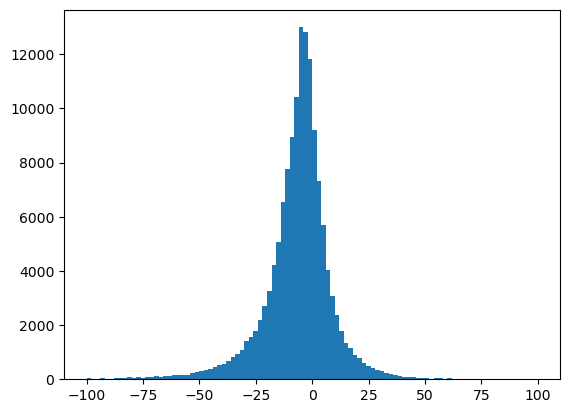

In [149]:
## Plot the histogram 

plt.hist(delta_price, bins = 100)
plt.show()

In [239]:
## Normal fit Parameters: Mean and std of delta_price

mean = np.mean(delta_price)
std = np.std(delta_price)

mean, std 
# note that mean < 0 means that on average DAP is forecasted higher than the realized RTP
# perhaps a more conservative bidder will have a better chance of clearing...

(-6.317469485927446, 15.393273573164219)

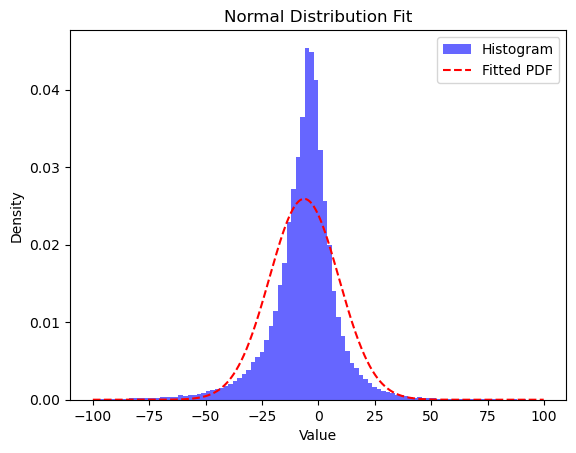

In [285]:
## Normal Distribution Fit

x = np.linspace(min(delta_price), max(delta_price), 1000)
fitted_pdf = norm.pdf(x, loc=mean, scale=std)

# Plot
plt.hist(delta_price, bins=100, density=True, alpha=0.6, color='b', label="Histogram")
plt.plot(x, fitted_pdf, 'r--', label="Fitted PDF")
plt.title("Normal Distribution Fit")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [287]:
# Perform the Kolmogorov-Smirnov (KS) test
ks_stat, p_value = kstest(delta_price, 'norm', args=(mean, std))
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

# Note: Low p-value (≤ 0.05) means that the data does not fit the normal distribution.

KS Statistic: 0.09736525020123662, p-value: 0.0


In [289]:
## Sample values (x, y, z)

x = SCE_SP15.dap[0] # x := DAP at ts = 1 (can replace with bid at time t)
y = SCE_SP15.rtp[0] # y := RTP at ts = 1 (target, ground truth)
z = y - x
x, y, z

(30.02044, 26.13978, -3.8806600000000024)

In [330]:
# The PDF describes the likelihood of a random variable taking a specific value
# Note: since the normal is not a good fit, we see that this pdf returns a low value even when z is within 1 std of the mean

pdf_value = norm.pdf(z, loc=mean, scale=std)
print("PDF at z:", pdf_value)

PDF at z: 0.02559395292048283


### Beta Distribution

#### Normalized Data

In [263]:
## Min Max Normalize Data to [-1, 1]
data_min, data_max = min(delta_price), max(delta_price)
delta_price_norm = (delta_price - data_min) / (data_max - data_min)

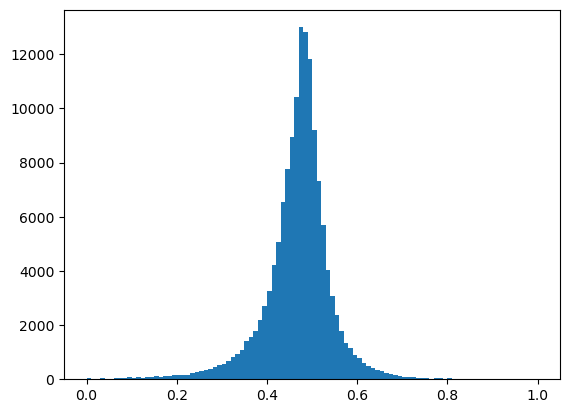

In [311]:
# Plot the normalized histogram
plt.hist(delta_price_norm, bins = 100)
plt.show()

In [304]:
from scipy.stats import beta

# Fit beta distribution to minmax normalized data
params = beta.fit(delta_price_norm)
print(f"Fitted parameters (alpha, beta, loc, scale): {params}")
alpha = params[0]
beta_param = params[1]

# Evaluate goodness-of-fit
ks_stat, p_value = kstest(delta_price_norm, 'beta', args=params)
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Fitted parameters (alpha, beta, loc, scale): (1983.1492890315762, 202.14287975430295, -10.746517490555842, 12.358297556547925)
KS Statistic: 0.09060227640222543, p-value: 0.0


In [313]:
## Compute Beta PDF

# Generate x-values for plotting
x = np.linspace(data_min, data_max, 1000)
x_norm = (x - data_min) / (data_max - data_min)  # Normalize x to [0, 1]

beta_pdf = beta.pdf(x_norm, alpha, beta_param, loc=params[2], scale=params[3])

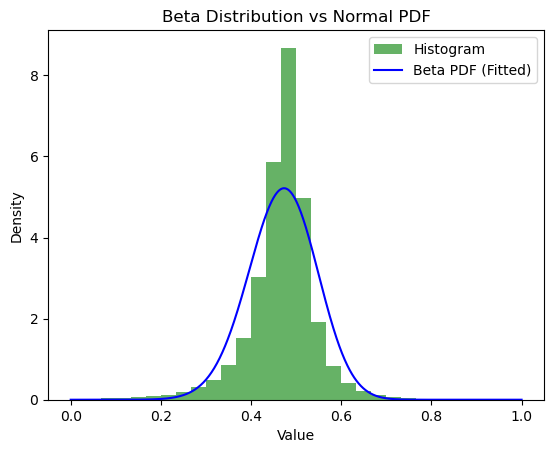

In [323]:
## Plot Beta PDF over normalized data

plt.hist(delta_price_norm, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
plt.plot(x_norm, beta_pdf, 'b-', label="Beta PDF (Fitted)")
plt.title("Beta Distribution vs Normal PDF")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [336]:
## Test point

# The PDF describes the likelihood of a random variable taking a specific value
# Note: since the normal is not a good fit, we see that this pdf returns a low value even when z is within 1 std of the mean

# normalize our test data point
z_norm = (z - data_min) / (data_max - data_min) 

beta_pdf_value = beta.pdf(z_norm, alpha, beta_param, loc=params[2], scale=params[3])
print("PDF at z:", beta_pdf_value)

PDF at z: 5.190091021435838


##### Summmary: 
Both the beta and normal distributions have a poor fit, but could be used to roughly govern bids if we map the density range to the power output range


## Inverted Absolute Value Function

In [368]:
# Define the function
def inverted_abs_symmetric(x):
    return np.maximum(0, 1 - np.abs(x) / 100)

# Generate values for plotting
x = np.linspace(-120, 120, 500)  # Range from -120 to 120
y = inverted_abs_symmetric(x)

In [360]:
abs_pdf_value = inverted_abs_symmetric(z)
print("PDF at z:", abs_pdf_value)

PDF at z: 0.9611934


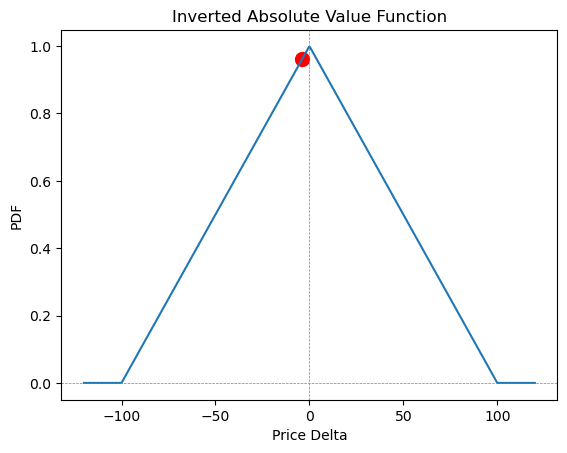

In [372]:
# Plot the function
plt.plot(x, y, label="Inverted Absolute Function")
# Add the test point
plt.scatter(z, abs_pdf_value, color='red', s=100)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("Inverted Absolute Value Function")
plt.xlabel("Price Delta")
plt.ylabel("PDF")
plt.show()

## Kernal Density Estimation

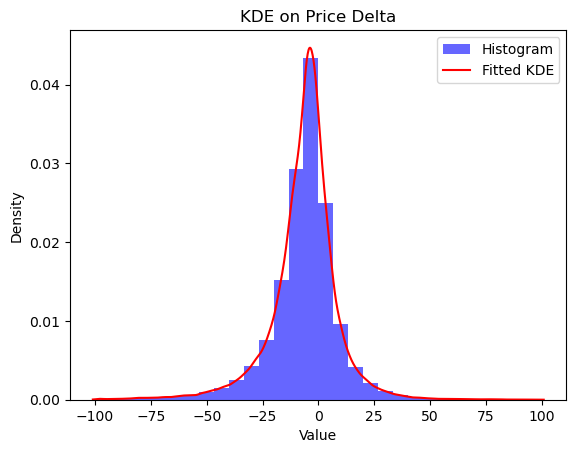

In [424]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = delta_price

# Perform KDE
kde = gaussian_kde(data)
x = np.linspace(min(data) - 1, max(data) + 1, 1000)
y = kde(x)

# Plot
plt.hist(delta_price, bins=30, density=True, alpha=0.6, color='b', label="Histogram")
plt.plot(x, y, color='r', label="Fitted KDE")
plt.title('KDE on Price Delta')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [418]:
## Test point
print("PDF at z:", kde(z)[0])

PDF at z: 0.04467675137128575


#### Summary: 
Low density means larger spread, we could:
1. Restrict the data more
2. Scale it
4. Try more detailed methods

**Next steps:** wrap this in a class for integration